In [14]:
import os
import numpy as np
import tensorflow as tf
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

### Importing LOL Dataset

In [15]:
from skimage.io import imread

In [16]:
path='LOL/train/low/'
train_low=[]
for img in os.listdir('LOL/train/low/'):
  if(img.endswith('.png')):
    img=(np.array(imread(path+img))/255.0).astype(np.float32)
    train_low.append(img)

In [17]:
path='LOL/train/high/'
train_high=[]
for img in os.listdir('LOL/train/high/'):
  if(img.endswith('.png')):
    img=(np.array(imread(path+img))/255.0).astype(np.float32)
    train_high.append(img)

In [18]:
path='LOL/test/low/'
test_low=[]
for img in os.listdir('LOL/test/low/'):
  if(img.endswith('.png')):
    img=(np.array(imread(path+img))/255.0).astype(np.float32)
    test_low.append(img)

In [19]:
path='LOL/test/high/'
test_high=[]
for img in os.listdir('LOL/test/high/'):
  if(img.endswith('.png')):
    img=(np.array(imread(path+img))/255.0).astype(np.float32)
    test_high.append(img)

### Import ExDark Dataset

In [20]:
ex_dark=[]
for img in os.listdir('ExDark//'):
  img=(np.array(imread('ExDark//'+img))/255.0).astype(np.float32)
  if(img.shape[-1]==3):
    ex_dark.append(img)

In [21]:
ex_dark=[resize(img,(256,256)) for img in ex_dark]

In [22]:
ex_dark=tf.convert_to_tensor(np.array(ex_dark))

In [23]:
ex_dark_attention=tf.image.rgb_to_grayscale(tf.convert_to_tensor([(1-ex_dark[i])**1.5 for i in range(len(ex_dark))]))

In [24]:
BATCH_SIZE=8
ex_dark_data=tf.data.Dataset.from_tensor_slices(ex_dark).batch(BATCH_SIZE)
ex_dark_input_data=tf.data.Dataset.from_tensor_slices(tf.concat([ex_dark,ex_dark_attention],axis=-1)).batch(BATCH_SIZE)

### LSRW Dataset

In [25]:
lsrw_low_imgs=[]
for img in os.listdir('lsrw/low/'):
  img=(np.array(imread('lsrw/low/'+img))/255.0).astype(np.float32)
  lsrw_low_imgs.append(img)

In [26]:
lsrw_high_imgs=[]
for img in os.listdir('lsrw/high/'):
  img=(np.array(imread('lsrw/high/'+img))/255.0).astype(np.float32)
  lsrw_high_imgs.append(img)

In [27]:
lsrw_low_imgs=[resize(img,(256,256)) for img in lsrw_low_imgs]
lsrw_high_imgs=[resize(img,(256,256)) for img in lsrw_high_imgs]

In [28]:
print(len(lsrw_low_imgs))
print(len(lsrw_high_imgs))

50
50


In [29]:
lsrw_low_attention=tf.image.rgb_to_grayscale(tf.convert_to_tensor([(1-lsrw_low_imgs[i])**1.5 for i in range(len(lsrw_low_imgs))]))
lsrw_high_attention=tf.image.rgb_to_grayscale(tf.convert_to_tensor([(1-lsrw_high_imgs[i])**1.5 for i in range(len(lsrw_high_imgs))]))

In [30]:
BATCH_SIZE=8
lsrw_low_data=tf.data.Dataset.from_tensor_slices(lsrw_low_imgs).batch(BATCH_SIZE)
lsrw_low_input_data=tf.data.Dataset.from_tensor_slices(tf.concat([lsrw_low_imgs,lsrw_low_attention],axis=-1)).batch(BATCH_SIZE)
lsrw_high_data=tf.data.Dataset.from_tensor_slices(lsrw_high_imgs).batch(BATCH_SIZE)
lsrw_high_input_data=tf.data.Dataset.from_tensor_slices(tf.concat([lsrw_high_imgs,lsrw_high_attention],axis=-1)).batch(BATCH_SIZE)

### Data Preprocessing

In [31]:
from skimage.transform import resize

In [32]:
#Resizing already normalized images to (256,256)
train_low=[resize(img,(256,256)) for img in train_low]
train_high=[resize(img,(256,256)) for img in train_high]
test_low=[resize(img,(256,256)) for img in test_low]
test_high=[resize(img,(256,256)) for img in test_high]

In [33]:
#Image Normalization to range [0,1] already done while importing image datasets
#Attention Component
train_attention=tf.image.rgb_to_grayscale(tf.convert_to_tensor([(1-train_low[i])**1.5 for i in range(len(train_low))]))
test_attention=tf.image.rgb_to_grayscale(tf.convert_to_tensor([(1-test_low[i])**1.5 for i in range(len(test_low))]))

In [34]:
# Tensor Batches
BATCH_SIZE=8
train_low_data=tf.data.Dataset.from_tensor_slices(train_low).batch(BATCH_SIZE)
train_high_data=tf.data.Dataset.from_tensor_slices(train_high).batch(BATCH_SIZE)
train_input_data=tf.data.Dataset.from_tensor_slices(tf.concat([train_low,train_attention],axis=-1)).batch(BATCH_SIZE)
test_low_data=tf.data.Dataset.from_tensor_slices(test_low).batch(BATCH_SIZE)
test_high_data=tf.data.Dataset.from_tensor_slices(test_high).batch(BATCH_SIZE)
test_input_data=tf.data.Dataset.from_tensor_slices(tf.concat([test_low,test_attention],axis=-1)).batch(BATCH_SIZE)

### Model Building

In [35]:
from keras.layers import Input,Conv2D,UpSampling2D,Lambda,Multiply,Concatenate,LeakyReLU,BatchNormalization,Conv2DTranspose,Activation,Subtract
from keras.models import Model

In [36]:
def u_net_plus_plus():
  inp=Input(shape=(256,256,4))
  low_img=inp[:,:,:,0:3]
  attn_map=Lambda(lambda x: tf.expand_dims(x,axis=-1))(inp[:,:,:,3])

  #Downsampling
  conv1=Conv2D(filters=3,kernel_size=(3,3),strides=2,activation=tf.keras.activations.relu,padding='same')(inp) #x(0,0) (128,128,3)
  conv1=BatchNormalization()(conv1)

  conv2=Conv2D(filters=3,kernel_size=(3,3),strides=2,activation=tf.keras.activations.relu,padding='same')(conv1) #x(1,0) (64,64,3)
  conv2=BatchNormalization()(conv2)
  conv2_up=UpSampling2D(size=(2, 2), interpolation='nearest')(conv2)
  conv2_up=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(conv2_up) #(128,128,3)
  low_img_resized=Lambda(lambda x: tf.image.resize(x,size=(conv2.shape[1],conv2.shape[2])))(low_img) #(64,64,3)
  attn_map_resized=Lambda(lambda x: tf.image.resize(x,size=(conv2.shape[1],conv2.shape[2])))(attn_map) #(64,64,1)
  conv3_inp=Concatenate()([conv2,low_img_resized,attn_map_resized]) #(64,64,7)

  conv3=Conv2D(filters=3,kernel_size=(3,3),strides=2,activation=tf.keras.activations.relu,padding='same')(conv3_inp) #x(2,0) (32,32,3)
  conv3=BatchNormalization()(conv3)
  conv3_up=UpSampling2D(size=(2, 2), interpolation='nearest')(conv3)
  conv3_up=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(conv3_up) #(64,64,3)
  conv3_up_up=UpSampling2D(size=(2, 2), interpolation='nearest')(conv3_up)
  conv3_up_up=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(conv3_up_up) #(128,128,3)

  conv4=Conv2D(filters=3,kernel_size=(3,3),strides=2,activation=tf.keras.activations.relu,padding='same')(conv3) #x(3,0) (16,16,3)
  conv4=BatchNormalization()(conv4)
  conv4_up=UpSampling2D(size=(2, 2), interpolation='nearest')(conv4)
  conv4_up=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(conv4_up) #(32,32,3)
  conv4_up_up=UpSampling2D(size=(2, 2), interpolation='nearest')(conv4_up)
  conv4_up_up=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(conv4_up_up) #(64,64,3)
  conv4_up_up_up=UpSampling2D(size=(2, 2), interpolation='nearest')(conv4_up_up)
  conv4_up_up_up=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(conv4_up_up_up) #(128,128,3)
  low_img_resized=Lambda(lambda x: tf.image.resize(x,size=(conv4.shape[1],conv4.shape[2])))(low_img) #(16,16,3)
  attn_map_resized=Lambda(lambda x: tf.image.resize(x,size=(conv4.shape[1],conv4.shape[2])))(attn_map) #(16,16,1)
  conv5_inp=Concatenate()([conv4,low_img_resized,attn_map_resized]) #(16,16,7)

  conv5=Conv2D(filters=3,kernel_size=(3,3),strides=2,activation=tf.keras.activations.relu,padding='same')(conv5_inp) #x(4,0) (8,8,3)
  conv5=BatchNormalization()(conv5)
  conv5_up=UpSampling2D(size=(2, 2), interpolation='nearest')(conv5)
  conv5_up=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(conv5_up) #(16,16,3)
  conv5_up_up=UpSampling2D(size=(2, 2), interpolation='nearest')(conv5_up)
  conv5_up_up=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(conv5_up_up) #(32,32,3)
  conv5_up_up_up=UpSampling2D(size=(2, 2), interpolation='nearest')(conv5_up_up)
  conv5_up_up_up=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(conv5_up_up_up) #(64,64,3)
  conv5_up_up_up_up=UpSampling2D(size=(2, 2), interpolation='nearest')(conv5_up_up_up)
  conv5_up_up_up_up=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(conv5_up_up_up_up) #(128,128,3)

  conv6=Conv2D(filters=3,kernel_size=(3,3),strides=2,activation=tf.keras.activations.relu,padding='same')(conv5) #x(5,0) (4,4,3)
  conv6=BatchNormalization()(conv6)
  #Upsampling
  upsample_1=UpSampling2D(size=(2, 2), interpolation='nearest')(conv6)
  upsample_1=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(upsample_1) #(8,8,3)
  #upsample_1=BatchNormalization()(upsample_1)
  upsample_2_inp=Concatenate()([conv5,upsample_1]) #(8,8,6)

  upsample_2=UpSampling2D(size=(2, 2), interpolation='nearest')(upsample_2_inp)
  upsample_2=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(upsample_2) #(16,16,3)
  upsample_2=BatchNormalization()(upsample_2)
  skip1=Concatenate()([conv4,conv5_up])
  skip2=Concatenate()([conv5_up,upsample_2])
  skip3=Concatenate()([conv4,upsample_2])
  upsample_3_inp=Concatenate()([upsample_2,skip1,skip2,skip3])

  upsample_3=UpSampling2D(size=(2, 2), interpolation='nearest')(upsample_3_inp)
  upsample_3=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(upsample_3)
  upsample_3=BatchNormalization()(upsample_3)
  skip1=Concatenate()([conv3,conv4_up])
  skip2=Concatenate()([conv4_up,conv5_up_up])
  skip3=Concatenate()([conv5_up_up,upsample_3])
  skip4=Concatenate()([conv3,conv5_up_up])
  skip5=Concatenate()([conv3,upsample_3])
  skip6=Concatenate()([conv4_up,upsample_3])
  upsample_4_inp=Concatenate()([upsample_3,skip1,skip2,skip3,skip4,skip5,skip6])

  upsample_4=UpSampling2D(size=(2, 2), interpolation='nearest')(upsample_4_inp)
  upsample_4=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(upsample_4)
  upsample_4=BatchNormalization()(upsample_4)
  skip1=Concatenate()([conv2,conv3_up])
  skip2=Concatenate()([conv3_up,conv4_up_up])
  skip3=Concatenate()([conv4_up_up,conv5_up_up_up])
  skip4=Concatenate()([conv5_up_up_up,upsample_4])
  skip5=Concatenate()([conv2,conv4_up_up])
  skip6=Concatenate()([conv2,conv5_up_up_up])
  skip7=Concatenate()([conv2,upsample_4])
  skip8=Concatenate()([conv3_up,conv5_up_up_up])
  skip9=Concatenate()([conv3_up,upsample_4])
  skip10=Concatenate()([conv4_up_up,upsample_4])
  upsample_5_inp=Concatenate()([upsample_4,skip1,skip2,skip3,skip4,skip5,skip6,skip7,skip8,skip9,skip10])

  upsample_5=UpSampling2D(size=(2, 2), interpolation='nearest')(upsample_5_inp)
  upsample_5=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='relu')(upsample_5)
  upsample_5=BatchNormalization()(upsample_5)
  skip1=Concatenate()([conv1,conv2_up])
  skip2=Concatenate()([conv2_up,conv3_up_up])
  skip3=Concatenate()([conv3_up_up,conv4_up_up_up])
  skip4=Concatenate()([conv4_up_up_up,conv5_up_up_up_up])
  skip5=Concatenate()([conv5_up_up_up_up,upsample_5])
  skip6=Concatenate()([conv1,conv3_up_up])
  skip6=Concatenate()([conv1,conv4_up_up_up])
  skip7=Concatenate()([conv1,conv5_up_up_up_up])
  skip8=Concatenate()([conv1,upsample_5])
  skip9=Concatenate()([conv2_up,conv4_up_up_up])
  skip10=Concatenate()([conv2_up,conv5_up_up_up_up])
  skip11=Concatenate()([conv2_up,upsample_5])
  skip12=Concatenate()([conv3_up_up,conv5_up_up_up_up])
  skip13=Concatenate()([conv3_up_up,upsample_5])
  skip14=Concatenate()([conv4_up_up_up,upsample_5])
  latent_inp=Concatenate()([upsample_5,skip1,skip2,skip3,skip4,skip5,skip6,skip7,skip8,skip9,skip10,skip11,skip12,skip13,skip14])

  output=UpSampling2D(size=(2, 2), interpolation='nearest')(latent_inp)
  output=Conv2D(filters=3, kernel_size=(1,1), padding='same', activation=tf.keras.activations.sigmoid)(output)

  model=Model(inputs=inp,outputs=output)
  return model

In [37]:
generator=u_net_plus_plus()

In [38]:
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        111 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         12 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64, 3) │         84 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ get_item_1[0][0]  │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64, 3) │         12 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64, 64, 3) │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 64, 64, 1) │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64, 7) │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32, 3) │        192 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 3) │         12 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16, 3) │         84 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16, 3) │         12 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 16, 16, 3) │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 16, 16, 1) │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16, 7) │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ lambda_3[0][0],   │
│                     │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,662 (6.49 KB)

 Trainable params: 1,602 (6.26 KB)

 Non-trainable params: 60 (240.00 B)

In [39]:
def global_discriminator():
    inp=Input(shape=(256,256,6))

    #Discriminator
    conv1=Conv2D(filters=64,kernel_size=(4,4),strides=2,padding='same')(inp) #(128,128,64)
    conv1=LeakyReLU(alpha=0.2)(conv1)
    conv2=Conv2D(filters=128,kernel_size=(4,4),strides=2,padding='same')(conv1) #(64,64,128)
    conv2=BatchNormalization()(conv2)
    conv2=LeakyReLU(alpha=0.2)(conv2)
    conv3=Conv2D(filters=256,kernel_size=(4,4),strides=2,padding='same')(conv2) #(32,32,256)
    conv3=BatchNormalization()(conv3)
    conv3=LeakyReLU(alpha=0.2)(conv3)
    conv4=Conv2D(filters=512,kernel_size=(4,4),strides=2,padding='same')(conv3) #(16,16,512)
    conv4=BatchNormalization()(conv4)
    conv4=LeakyReLU(alpha=0.2)(conv4)

    global_disc_op=Conv2D(filters=1,kernel_size=(16,16),strides=1,activation=tf.keras.activations.sigmoid)(conv4) #(1,1,1)

    model=Model(inputs=inp,outputs=global_disc_op)
    return model

In [40]:
glob_discriminator=global_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [41]:
glob_discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 64)   │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 1, 1, 1)        │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,894,273 (11.04 MB)

 Trainable params: 2,892,481 (11.03 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [42]:
def local_discriminator():
    inp=Input(shape=(64,64,6))
    gen_img_patch=inp[:,:,:,0:3]
    high_img_patch=inp[:,:,:,3:6]

    #Discriminator
    disc_input=Concatenate()([gen_img_patch,high_img_patch]) #(64,64,6)
    conv1=Conv2D(filters=64,kernel_size=(4,4),strides=2)(disc_input) #(31,31,64)
    conv1=LeakyReLU()(conv1)
    conv2=Conv2D(filters=128,kernel_size=(4,4),strides=2)(conv1) #(14,14,128)
    conv2=BatchNormalization()(conv2)
    conv2=LeakyReLU()(conv2)
    conv3=Conv2D(filters=256,kernel_size=(4,4),strides=2)(conv2) #(6,6,256)
    conv3=BatchNormalization()(conv3)
    conv3=LeakyReLU()(conv3)
    conv4=Conv2D(filters=512,kernel_size=(4,4),strides=2)(conv3) #(2,2,512)
    conv4=BatchNormalization()(conv4)
    conv4=LeakyReLU()(conv4)
    output=Conv2D(filters=1,kernel_size=(2,2),strides=1,activation=tf.keras.activations.sigmoid)(conv4)
    model=Model(inputs=inp,outputs=output)
    return model

In [43]:
loc_discriminator=local_discriminator()

In [44]:
loc_discriminator.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 6) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64, 64, 3) │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 64, 64, 3) │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_41      │ (None, 64, 64, 6) │          0 │ get_item_2[0][0], │
│ (Concatenate)       │                   │            │ get_item_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 31, 31,    │      6,208 │ concatenate_41[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 31, 31,    │          0 │ conv2d_27[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 14, 14,    │    131,200 │ leaky_re_lu_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 6, 6, 256) │    524,544 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 256) │      1,024 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 6, 6, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 2, 2, 512) │  2,097,664 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 2, 2, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 1, 1, 1)   │      2,049 │ leaky_re_lu_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,765,249 (10.55 MB)

 Trainable params: 2,763,457 (10.54 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Loss and Optimizer

In [45]:
 # Step 1: Create a feature extractor model using VGG19
def build_feature_extractor(layer_name='block3_conv3'):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False  # freeze VGG

    # Extract up to a certain intermediate layer
    model = Model(inputs=vgg.input, outputs=vgg.get_layer(layer_name).output)
    return model
def preprocess_input(x):
    x = tf.image.resize(x, (224, 224))  # VGG expects 224x224 input
    #x = preprocess_input(x * 255.0)     # Convert from [0,1] to [0,255] then normalize
    return x
# Step 2: Define the feature loss function
def compute_feature_loss(input_img, gen_img, extractor):
    # Resize and preprocess images to match VGG input requirements
    input_img = tf.image.resize(input_img, (224, 224))
    gen_img = tf.image.resize(gen_img, (224, 224))

    input_img = preprocess_input(input_img * 255.0)  # scale to [0, 255] and normalize
    gen_img = preprocess_input(gen_img * 255.0)

    # Extract feature maps
    feat_input = extractor(input_img)
    feat_gen = extractor(gen_img)

    # Compute L1 loss between feature maps
    return tf.reduce_mean(tf.abs(feat_input - feat_gen))

In [46]:
def csf_mannos_sakrison_tf(f):
    return 2.6 * (0.0192 + 0.114 * f) * tf.exp(-tf.pow(0.114 * f, 1.1))

In [47]:
def fftfreq_tf(n, d=1.0):
    """TensorFlow equivalent of np.fft.fftfreq"""
    val = 1.0 / (n * d)
    N = tf.cast(n, tf.float32)
    results = tf.range(n)
    results = tf.where(results < n // 2, results, results - n)
    return tf.cast(results, tf.float32) * val

In [48]:
def fftshift_tf(x):
    """TensorFlow equivalent of np.fft.fftshift"""
    axes = tf.range(tf.rank(x))
    shifts = [dim // 2 for dim in x.shape]
    return tf.roll(x, shift=shifts, axis=axes)

In [49]:
def get_csf_weight_map(height, width, pixels_per_degree=60.0):
    u = fftfreq_tf(width) * width / pixels_per_degree
    v = fftfreq_tf(height) * height / pixels_per_degree

    U, V = tf.meshgrid(u, v)
    freq_magnitude = tf.sqrt(U ** 2 + V ** 2)

    csf = csf_mannos_sakrison_tf(freq_magnitude)
    return fftshift_tf(csf)

In [50]:
def visible_entropy(img, csf_weight):
    img_tf = tf.cast(img,tf.complex64)
    fft_img = tf.signal.fft2d(img_tf)
    mag = tf.abs(fft_img)
    weighted_mag = mag * csf_weight
    power = tf.square(weighted_mag)
    # Adding a small epsilon to the denominator to avoid division by zero
    prob = power / (tf.reduce_sum(power) + 1e-8)
    prob = tf.clip_by_value(prob, 1e-8, 1.0)
    entropy = -tf.reduce_sum(prob * tf.math.log(prob)) / tf.math.log(2.0)
    return entropy

In [51]:
def generator_loss(low_img,gen_img,high_img,gen_img_patch,high_img_patch,csf_weight,feature_extractor):
    term1=tf.reduce_mean(tf.square(tf.subtract(glob_discriminator(tf.concat([gen_img,high_img],axis=-1)),1)))
    term2=tf.reduce_mean(tf.square(glob_discriminator(tf.concat([high_img,gen_img],axis=-1))))
    L_G_global=tf.add(term1,term2)
    L_G_local=tf.reduce_mean(tf.square(tf.subtract(loc_discriminator(tf.concat([gen_img_patch,high_img_patch],axis=-1)),1)))
    L_F_global = compute_feature_loss(high_img, gen_img, feature_extractor)
    L_F_local = compute_feature_loss(high_img_patch, gen_img_patch, feature_extractor)

    #Saturation Loss
    saturation_low=tf.image.rgb_to_hsv(low_img)[:,:,1]
    saturation_low=tf.convert_to_tensor(saturation_low)
    saturation_gen=tf.image.rgb_to_hsv(gen_img)[:,:,1]
    saturation_gen=tf.convert_to_tensor(saturation_gen)
    L_S=tf.reduce_mean(tf.square(tf.subtract(saturation_low,saturation_gen)))

    #Visible Entropy Loss
    visible_entropy_loss=tf.abs(tf.subtract(8.0,visible_entropy(tf.image.rgb_to_grayscale(gen_img),csf_weight)))
    loss=tf.add_n([L_G_global,L_G_local,L_F_global,L_F_local,0.5*L_S,visible_entropy_loss])
    return loss

In [52]:
def global_disc_loss(gen_img,high_img):
    term1=tf.reduce_mean(tf.square(tf.subtract(glob_discriminator(tf.concat([high_img,gen_img],axis=-1)),1)))
    term2=tf.reduce_mean(tf.square(glob_discriminator(tf.concat([gen_img,high_img],axis=-1))))
    L_D_global=tf.add(term1,term2)
    return L_D_global

In [53]:
def local_disc_loss(gen_img_patch,high_img_patch):
    term1=tf.reduce_mean(tf.square(tf.subtract(loc_discriminator(tf.concat([high_img_patch,gen_img_patch],axis=-1)),1)))
    term2=tf.reduce_mean(tf.square(loc_discriminator(tf.concat([gen_img_patch,high_img_patch],axis=-1))))
    L_D_local=tf.add(term1,term2)
    return L_D_local

In [54]:
gen_optimizer=tf.keras.optimizers.AdamW(10**-3)
glob_disc_optimizer=tf.keras.optimizers.AdamW(10**-3)
loc_disc_optimizer=tf.keras.optimizers.AdamW(10**-3)

### Model Training

In [55]:
@tf.function
def train_step(low_attn_combined_img,high_img,csf_weight,feature_extractor):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as glob_disc_tape, tf.GradientTape() as loc_disc_tape:
        low_img=low_attn_combined_img[:,:,:,0:3]
        gen_img=generator(low_attn_combined_img)
        glob_disc_op=glob_discriminator(tf.concat([gen_img,high_img],axis=-1))

        current_batch_size = tf.shape(gen_img)[0]
        gen_img_patch=tf.image.random_crop(gen_img,size=(current_batch_size,64,64,3))
        high_img_patch=tf.image.random_crop(high_img,size=(current_batch_size,64,64,3))
        local_disc_op=loc_discriminator(tf.concat([gen_img_patch,high_img_patch],axis=-1))

        #Loss
        gen_loss=generator_loss(low_img,gen_img,high_img,gen_img_patch,high_img_patch,csf_weight,feature_extractor)
        glob_disc_loss=global_disc_loss(gen_img,high_img)
        loc_disc_loss=local_disc_loss(gen_img_patch,high_img_patch)

        #Gradients
        gen_gradients=gen_tape.gradient(gen_loss,generator.trainable_variables)
        glob_disc_gradients=glob_disc_tape.gradient(glob_disc_loss,glob_discriminator.trainable_variables)
        loc_disc_gradients=loc_disc_tape.gradient(loc_disc_loss,loc_discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(gen_gradients,generator.trainable_variables))
        glob_disc_optimizer.apply_gradients(zip(glob_disc_gradients,glob_discriminator.trainable_variables))
        loc_disc_optimizer.apply_gradients(zip(loc_disc_gradients,loc_discriminator.trainable_variables))
    return gen_loss,glob_disc_loss,loc_disc_loss

In [56]:
csf_weight=get_csf_weight_map(256,256)
csf_weight=tf.expand_dims(csf_weight,axis=-1)
feature_extractor=build_feature_extractor('block3_conv3')
for epoch in range(0,500):
    print("EPOCH:",epoch+1)
    for img_attn_combined,high_img in tf.data.Dataset.zip((train_input_data,train_high_data)):
        gen_loss,glob_disc_loss,loc_disc_loss=train_step(img_attn_combined,high_img,csf_weight,feature_extractor)
    print("Generator Loss:",gen_loss.numpy())
    print("Global Discriminator Loss:",glob_disc_loss.numpy())
    print("Local Discriminator Loss:",loc_disc_loss.numpy())

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EPOCH: 1


Generator Loss: 398.23538
Global Discriminator Loss: 1.0
Local Discriminator Loss: 1.0
EPOCH: 2
Generator Loss: 396.96722
Global Discriminator Loss: 1.0
Local Discriminator Loss: 1.0
EPOCH: 3
Generator Loss: 386.3183
Global Discriminator Loss: 1.0
Local Discriminator Loss: 1.0
EPOCH: 4
Generator Loss: 339.92505
Global Discriminator Loss: 1.0
Local Discriminator Loss: 1.0
EPOCH: 5
Generator Loss: 331.97968
Global Discriminator Loss: 1.0
Local Discriminator Loss: 1.0
EPOCH: 6
Generator Loss: 340.35437
Global Discriminator Loss: 1.0
Local Discriminator Loss: 1.0
EPOCH: 7
Generator Loss: 317.5552
Global Discriminator Loss: 1.0
Local Discriminator Loss: 1.0
EPOCH: 8
Generator Loss: 329.69193
Global Discriminator Loss: 1.0
Local Discriminator Loss: 1.0
EPOCH: 9
Generator Loss: 288.50253
Global Discriminator Loss: 1.0
Local Discriminator Loss: 1.0
EPOCH: 10
Generator Loss: 308.246
Global Discriminator Loss: 1.0
Local Discriminator Loss: 1.0
EPOCH: 11
Generator Loss: 305.1012
Global Discrimina

### Model Evaluation

In [57]:
pred=generator.predict(test_input_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


In [58]:
test_output_images=[]
for img in pred:
  test_output_images.append(img)

In [59]:
test_input_images=[]
for batch in test_input_data:
  for img in batch:
    test_input_images.append(img[:,:,0:3])

In [60]:
test_org_imgs=[]
for batch in test_high_data:
    for img in batch:
        test_org_imgs.append(img)

In [61]:
print(len(test_org_imgs))
print(len(test_output_images))
print(len(test_input_images))

15
15
15


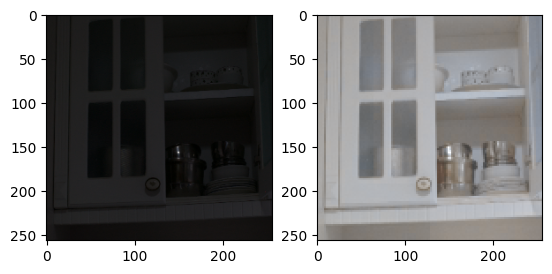

In [79]:
plt.subplot(1,2,1)
plt.imshow(test_input_images[12])
plt.subplot(1,2,2)
plt.imshow(test_output_images[12])
plt.show()

### ExDark

In [80]:
pred_ex_dark=generator.predict(ex_dark_input_data)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


In [81]:
test_output_images_ex_dark=[]
for img in pred_ex_dark:
  test_output_images_ex_dark.append(img)

In [82]:
test_input_images_ex_dark=[]
for batch in ex_dark_input_data:
  for img in batch:
    test_input_images_ex_dark.append(img[:,:,0:3])

In [83]:
print(len(test_output_images_ex_dark))
print(len(test_input_images_ex_dark))

235
235


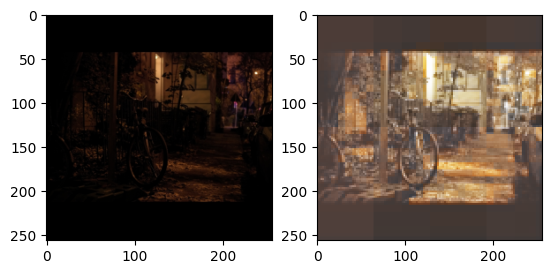

In [103]:
plt.subplot(1,2,1)
plt.imshow(test_input_images_ex_dark[18])
plt.subplot(1,2,2)
plt.imshow(test_output_images_ex_dark[18])
plt.show()

### LSRW

In [104]:
pred_lsrw=generator.predict(lsrw_low_input_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step


In [105]:
test_output_images_lsrw=[]
for img in pred_lsrw:
  test_output_images_lsrw.append(img)

In [106]:
test_input_images_lsrw=[]
for batch in lsrw_low_input_data:
  for img in batch:
    test_input_images_lsrw.append(img[:,:,0:3])

In [107]:
test_org_imgs_lsrw=[]
for batch in lsrw_high_data:
    for img in batch:
        test_org_imgs_lsrw.append(img)

In [108]:
print(len(test_org_imgs_lsrw))
print(len(test_output_images_lsrw))
print(len(test_input_images_lsrw))

50
50
50


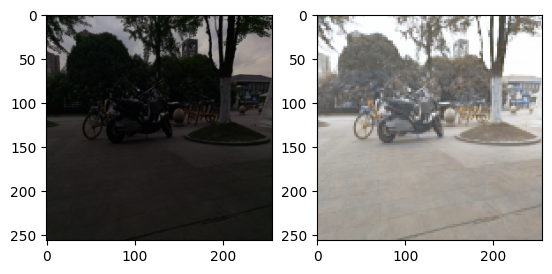

In [134]:
plt.subplot(1,2,1)
plt.imshow(test_input_images_lsrw[25])
plt.subplot(1,2,2)
plt.imshow(test_output_images_lsrw[25])
plt.show()

### PSNR

In [ ]:
psnr=tf.reduce_mean(tf.image.psnr(tf.convert_to_tensor(test_org_imgs),tf.convert_to_tensor(test_output_images),max_val=1.0)).numpy()
print("PSNR:",round(psnr,2))

PSNR: 17.98


In [ ]:
psnr_lsrw=tf.reduce_mean(tf.image.psnr(tf.convert_to_tensor(test_org_imgs_lsrw),tf.convert_to_tensor(test_output_images_lsrw),max_val=1.0)).numpy()
print("PSNR_lsrw:",round(psnr_lsrw,2))

PSNR_lsrw: 16.62


### SSIM

In [ ]:
ssim=tf.reduce_mean(tf.image.ssim(tf.convert_to_tensor(test_org_imgs),tf.convert_to_tensor(test_output_images),max_val=1.0)).numpy()
print("SSIM:",round(ssim,2))

SSIM: 0.74


In [ ]:
ssim_lsrw=tf.reduce_mean(tf.image.ssim(tf.convert_to_tensor(test_org_imgs_lsrw),tf.convert_to_tensor(test_output_images_lsrw),max_val=1.0)).numpy()
print("SSIM_lsrw:",round(ssim_lsrw,2))

SSIM_lsrw: 0.66


### PQMET Like Score

In [ ]:
pqmet_like_score_lst=[]
csf_weight=get_csf_weight_map(256,256)
csf_weight=tf.expand_dims(csf_weight,axis=-1)
for i in range(len(test_output_images)):
  org_visible_entropy=visible_entropy(test_org_imgs[i],csf_weight)
  output_visible_entropy=visible_entropy(test_output_images[i],csf_weight)
  pqmet_like_score=tf.divide(org_visible_entropy,output_visible_entropy).numpy()
  pqmet_like_score_lst.append(pqmet_like_score)
print("PQMET Like Score:",np.round(np.mean(pqmet_like_score_lst),2))

PQMET Like Score: 1.08


In [ ]:
pqmet_like_score_lst_lsrw=[]
csf_weight=get_csf_weight_map(256,256)
csf_weight=tf.expand_dims(csf_weight,axis=-1)
for i in range(len(test_output_images_lsrw)):
  org_visible_entropy_lsrw=visible_entropy(test_org_imgs_lsrw[i],csf_weight)
  output_visible_entropy_lsrw=visible_entropy(test_output_images_lsrw[i],csf_weight)
  pqmet_like_score_lsrw=tf.divide(org_visible_entropy_lsrw,output_visible_entropy_lsrw).numpy()
  pqmet_like_score_lst_lsrw.append(pqmet_like_score_lsrw)
print("PQMET Like Score_lsrw:",np.round(np.mean(pqmet_like_score_lst_lsrw),2))

PQMET Like Score_lsrw: 1.07


### BRISQUE

In [ ]:
from brisque import BRISQUE

In [ ]:
brisque_list=[]
for i in range(0,len(test_output_images)):
  brisque_score=BRISQUE().score(test_output_images[i])
  brisque_list.append(brisque_score)
print(round(np.mean(brisque_list),2))

20.78


In [ ]:
brisque_list_lsrw=[]
for i in range(0,len(test_output_images_lsrw)):
  brisque_score_lsrw=BRISQUE().score(test_output_images_lsrw[i])
  brisque_list_lsrw.append(brisque_score_lsrw)
print("BRISQUE Score_lsrw:",round(np.mean(brisque_list_lsrw),2))

BRISQUE Score_lsrw: 26.77


In [ ]:
brisque_list_ex_dark=[]
for i in range(0,len(test_output_images_ex_dark)):
  brisque_score_ex_dark=BRISQUE().score(test_output_images_ex_dark[i])
  brisque_list_ex_dark.append(brisque_score_ex_dark)
print("BRISQUE Score_ex_dark:",round(np.mean(brisque_list_ex_dark),2))

BRISQUE Score_ex_dark: 22.84


### Visual Information Fidelity (VIF)

In [ ]:
from sewar.full_ref import vifp

In [ ]:
vif_list=[]
for i in range(0,len(test_output_images)):
  test_output_images[i]=np.array(test_output_images[i])
  test_org_imgs[i]=np.array(test_org_imgs[i])
  vif_r=vifp(test_org_imgs[i][:,:,0],test_output_images[i][:,:,0])
  vif_g=vifp(test_org_imgs[i][:,:,1],test_output_images[i][:,:,1])
  vif_b=vifp(test_org_imgs[i][:,:,2],test_output_images[i][:,:,2])
  vif_img=np.mean([vif_r,vif_g,vif_b])
  vif_list.append(vif_img)
print(round(np.mean(vif_list),2))

0.34


In [ ]:
vif_list_lsrw=[]
for i in range(0,len(test_output_images_lsrw)):
  test_output_images_lsrw[i]=np.array(test_output_images_lsrw[i])
  test_org_imgs_lsrw[i]=np.array(test_org_imgs_lsrw[i])
  vif_r_lsrw=vifp(test_org_imgs_lsrw[i][:,:,0],test_output_images_lsrw[i][:,:,0])
  vif_g_lsrw=vifp(test_org_imgs_lsrw[i][:,:,1],test_output_images_lsrw[i][:,:,1])
  vif_b_lsrw=vifp(test_org_imgs_lsrw[i][:,:,2],test_output_images_lsrw[i][:,:,2])
  vif_img_lsrw=np.mean([vif_r_lsrw,vif_g_lsrw,vif_b_lsrw])
  vif_list_lsrw.append(vif_img_lsrw)
print("VIF_lsrw",round(np.mean(vif_list_lsrw),2))

VIF_lsrw 0.36


### Lightness Order Error (LOE)

In [ ]:
from skimage import color
from skimage.transform import resize

In [ ]:
def loe_metric(original, enhanced, downsample=50):

    # Convert to grayscale
    orig_gray = color.rgb2gray(original)
    enh_gray = color.rgb2gray(enhanced)

    # Downsample for speed
    h, w = orig_gray.shape
    new_h, new_w = max(h // downsample, 50), max(w // downsample, 50)
    orig_ds = resize(orig_gray, (new_w, new_h))
    enh_ds = resize(enh_gray, (new_w, new_h))

    # Flatten
    orig_flat = orig_ds.flatten()
    enh_flat = enh_ds.flatten()
    N = orig_flat.shape[0]

    # Broadcasted pairwise comparisons
    orig_matrix = orig_flat[:, None] >= orig_flat[None, :]
    enh_matrix  = enh_flat[:, None]  >= enh_flat[None, :]

    # Relative order differences
    diff_matrix = orig_matrix != enh_matrix
    loe_sum = diff_matrix.sum(axis=1)
    loe_score = loe_sum.mean()

    return loe_score

In [ ]:
loe_score_list=[]
for i in range(0,len(test_output_images)):
  test_output_images[i]=np.array(test_output_images[i])
  test_org_imgs[i]=np.array(test_org_imgs[i])
  loe_score=loe_metric(test_input_images[i], test_output_images[i], downsample=50)
  loe_score_list.append(loe_score)
print(round(np.mean(loe_score_list),2))

92.12


In [ ]:
loe_score_list_lsrw=[]
for i in range(0,len(test_output_images_lsrw)):
  test_output_images_lsrw[i]=np.array(test_output_images_lsrw[i])
  test_org_imgs_lsrw[i]=np.array(test_org_imgs_lsrw[i])
  loe_score_lsrw=loe_metric(test_input_images_lsrw[i], test_output_images_lsrw[i], downsample=50)
  loe_score_list_lsrw.append(loe_score_lsrw)
print("LOE_lsrw",round(np.mean(loe_score_list_lsrw),2))

LOE_lsrw 151.04


In [ ]:
loe_score_list_ex_dark=[]
for i in range(0,len(test_output_images_ex_dark)):
  test_output_images_ex_dark[i]=np.array(test_output_images_ex_dark[i])
  loe_score_ex_dark=loe_metric(test_input_images_ex_dark[i], test_output_images_ex_dark[i], downsample=50)
  loe_score_list_ex_dark.append(loe_score_ex_dark)
print("LOE_ex_dark",round(np.mean(loe_score_list_ex_dark),2))

LOE_ex_dark 165.55


### NIQE

In [ ]:
from google.colab import files

In [ ]:
np.save("my_unet_pred.npy",np.array(test_output_images))
files.download('my_unet_pred.npy')

In [ ]:
np.save("my_unet_pred_lsrw.npy",np.array(test_output_images_lsrw))
files.download('my_unet_pred_lsrw.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.save("my_unet_pred_ex_dark.npy",np.array(test_output_images_ex_dark))
files.download('my_unet_pred_ex_dark.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Entropy

In [ ]:
from skimage.measure import shannon_entropy

In [ ]:
entropy_lst=[]
for img in test_output_images:
  gray = color.rgb2gray(img)
  gray_uint8 = (gray * 255).astype(np.uint8)
  entropy_value = shannon_entropy(gray_uint8)
  entropy_lst.append(entropy_value)
print(np.round(np.mean(entropy_lst),2))

6.48


In [ ]:
entropy_lst_lsrw=[]
for img in test_output_images_lsrw:
  gray = color.rgb2gray(img)
  gray_uint8 = (gray * 255).astype(np.uint8)
  entropy_value_lsrw = shannon_entropy(gray_uint8)
  entropy_lst_lsrw.append(entropy_value_lsrw)
print("Entropy_lsrw",np.round(np.mean(entropy_lst_lsrw),2))

Entropy_lsrw 6.65


In [ ]:
entropy_lst_ex_dark=[]
for img in test_output_images_ex_dark:
  gray = color.rgb2gray(img)
  gray_uint8 = (gray * 255).astype(np.uint8)
  entropy_value_ex_dark = shannon_entropy(gray_uint8)
  entropy_lst_ex_dark.append(entropy_value_ex_dark)
print("Entropy_lsrw",np.round(np.mean(entropy_lst_ex_dark),2))

Entropy_lsrw 6.9
